# CVPR2021 安全AI挑战者计划第六期：ImageNet无限制对抗攻击

In [1]:
!nvidia-smi

Thu Mar 18 15:50:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Data & Insatll pkg 

| 名称         | 大小     |                           Link |
| :----------- | :------- | ------------------------------: |
| imagenet_round1_210122.zip | 212.89MB |  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round1_210122.zip  |

In [2]:
!rm -rf /content/sample_data
!rm -rf /content/imagenet_round1_210122.zip
!rm -rf /content/dataset
!wget https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round1_210122.zip
#!cp -r '/content/drive/Shareddrives/ACloudDrive/Tianchi/安全AI挑战者第六期赛道一/imagenet_round1_210122.zip' ./
!unzip -q imagenet_round1_210122.zip 
!unzip -q images.zip 

!mkdir dataset
!mv images dataset
!cp -r /content/dev.csv /content/dataset/
!rm -rf im*
!rm -rf dev.csv

--2021-03-18 15:50:51--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round1_210122.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223227101 (213M) [application/zip]
Saving to: ‘imagenet_round1_210122.zip’

imagenet_round1_210 100%[===================>] 212.89M  4.99MB/s    in 45s     

2021-03-18 15:51:39 (4.72 MB/s) - ‘imagenet_round1_210122.zip’ saved [223227101/223227101]



In [3]:
!pip install  torchattacks --force-reinstall
!pip install efficientnet_pytorch

     |████████████████████████████████| 81kB 6.9MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=f1290b0dce120887b96e69a00322f162792cc156385285586050cac09187f907
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


## Load Data

In [4]:
import numpy as np
import json
import os
import sys
import time
import pandas as pd

In [5]:
dev = pd.read_csv('dataset/dev.csv')
dev.head()

,ImageId,TrueLabel
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [6]:
dev['ImageId'] = dev['ImageId'].astype('str')
dev['ImageId'] = 'dataset/images/' + dev['ImageId'] 

train_data =dev['ImageId'] 
train_data

0          dataset/images/0.jpg
1          dataset/images/1.jpg
2          dataset/images/2.jpg
3          dataset/images/3.jpg
4          dataset/images/4.jpg
                 ...           
4995    dataset/images/4995.jpg
4996    dataset/images/4996.jpg
4997    dataset/images/4997.jpg
4998    dataset/images/4998.jpg
4999    dataset/images/4999.jpg
Name: ImageId, Length: 5000, dtype: object

In [7]:
!rm -rf newdata
!mkdir newdata

In [8]:
from tqdm import tqdm
import shutil
from shutil import copyfile
# trainset
for i in tqdm(range(0, 1000)):
    train_path = 'newdata/{}'.format(i)
    os.makedirs(train_path)
    for j in range(i*5, i*5+5):     
        shutil.copy(train_data.iloc[j], train_path)
print(len(os.listdir(train_path))/2)

100%|██████████| 1000/1000 [00:00<00:00, 1148.18it/s]

2.5


# PGD

In [9]:
import numpy as np
import json
import os
import sys
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.utils
from torchvision import models
import torchvision.transforms as transforms
import torchattacks

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [12]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    #plt.title(title)
    plt.show()
    

def l2_distance(model, images, adv_images, labels, device="cuda"):
    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1)
    corrects = (labels.to(device) == pre)
    delta = (adv_images - images.to(device)).view(len(images), -1)
    l2 = torch.norm(delta[~corrects], p=2, dim=1).mean()
    return l2

In [14]:
transform = transforms.Compose([
    #transforms.Resize((500, 500)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1] 
    ])

## ImageFolder

In [15]:
import os
import torch
import torch.utils.data as data
from PIL import Image
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

class VisionDataset(data.Dataset):
    _repr_indent = 4

    def __init__(
            self,
            root: str,
            transforms: Optional[Callable] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ) -> None:
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root

        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")

        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform

        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms

    def __getitem__(self, index: int) -> Any:
        raise NotImplementedError

    def __len__(self) -> int:
        raise NotImplementedError

    def __repr__(self) -> str:
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if hasattr(self, "transforms") and self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def extra_repr(self) -> str:
        return ""

def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
    return filename.lower().endswith(extensions)


def is_image_file(filename: str) -> bool:
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)

def make_dataset(
    directory: str,
    class_to_idx: Dict[str, int],
    extensions: Optional[Tuple[str, ...]] = None,
    is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    instances = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, cast(Tuple[str, ...], extensions))
    is_valid_file = cast(Callable[[str], bool], is_valid_file)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances

class DatasetFolder(VisionDataset):
    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super(DatasetFolder, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        if len(samples) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.root)
            if extensions is not None:
                msg += "Supported extensions are: {}".format(",".join(extensions))
            raise RuntimeError(msg)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        ######
        classes.sort(key =int)
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

# TODO: specify the return type
def accimage_loader(path: str) -> Any:
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class ImageFolder(DatasetFolder):

    def __init__(
            self,
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            loader: Callable[[str], Any] = default_loader,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super(ImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

class StandardTransform(object):
    def __init__(self, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        self.transform = transform
        self.target_transform = target_transform

    def __call__(self, input: Any, target: Any) -> Tuple[Any, Any]:
        if self.transform is not None:
            input = self.transform(input)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return input, target

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def __repr__(self) -> str:
        body = [self.__class__.__name__]
        if self.transform is not None:
            body += self._format_transform_repr(self.transform,
                                                "Transform: ")
        if self.target_transform is not None:
            body += self._format_transform_repr(self.target_transform,
                                                "Target transform: ")

        return '\n'.join(body)

## attack

In [16]:
root = '/content/newdata'
imagnet_data = ImageFolder(root=root, transform=transform)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)
print(len(data_loader))

5000


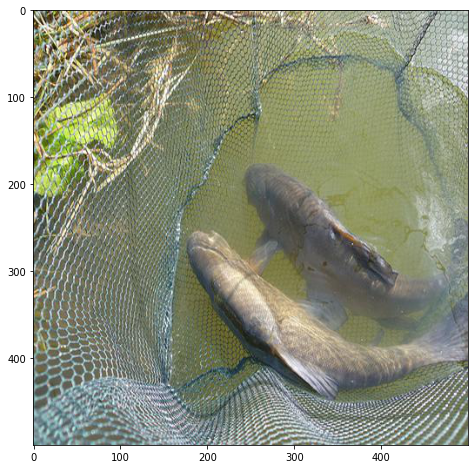

In [17]:
images, labels = iter(data_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

In [18]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [19]:
from efficientnet_pytorch import EfficientNet
# Adding a normalization layer for Inception v3.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(norm_layer, EfficientNet.from_pretrained('efficientnet-b5')).to(device)
 
#model = EfficientNet.from_pretrained('efficientnet-b5').to(device)
model = model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


## attack mode

In [20]:
#Target mode
# atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=50)
# target_map_function = lambda images, labels: labels.fill_(random.randint(1,999))
# atk.set_mode_targeted(target_map_function=target_map_function)

#Least Likely
atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100) #扰动8个像素点
atk.set_mode_least_likely()


#Random_start 
# pgd = torchattacks.PGD(model, eps=4/255, alpha=2/255, steps=50, random_start=True)
# atk = torchattacks.MultiAttack([pgd]*10)

#CW
# c_candidate = [1, 0.1, 0.01, 0.001]
# atk = torchattacks.MultiAttack([torchattacks.CW(model, c, kappa=0, steps=1000, lr=0.01) for c in c_candidate])

#AutoAttack
# atk = torchattacks.AutoAttack(model, norm='Linf', eps=0.12, version='plus', n_classes=1000, seed=42, verbose=False)

#Squre
# atk = torchattacks.Square(model, norm='Linf', n_queries=5000, 
#                           n_restarts=1, eps=None, p_init=.8, seed=0, 
#                           verbose=False, targeted=False, loss='margin', 
#                           resc_schedule=True)

In [21]:
# 对抗样本效果
count = 0
for images, labels in data_loader:
    print(int(labels.numpy()))
    
    count = count + 1
    # 原始样本show
    imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])
     
    # 对抗样本show 
    adv_images = atk(images, labels)
    labels = labels.to(device)
    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1) 
    imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])
    if count >=10:
        break

Output hidden; open in https://colab.research.google.com to view.

In [22]:
from PIL import Image
# loader使用torchvision中自带的transforms函数

unloader = transforms.ToPILImage()
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

In [23]:
!rm -rf /content/images
!mkdir /content/images

In [24]:
idx=0
for images, labels in tqdm((data_loader)):

    name_idx = int(labels.numpy())*5 + idx
    idx = idx + 1
    if idx ==5:
        idx=0
        
    adv_images = atk(images, labels) # input labels will be ignored in least likely mode.
    labels = labels.to(device)
    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1)

    image = tensor_to_PIL(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True))
    #image = image.resize((500, 500))
    
    img_name='images/{}.jpg'.format(name_idx)
    image.save(img_name, quality=75)

100%|██████████| 5000/5000 [6:39:35<00:00,  4.80s/it]


In [25]:
!zip -r -q images.zip images/*.jpg

In [26]:
!cp -r /content/images.zip '/content/drive/MyDrive/Colab Notebooks/Tianchi/CVPR2021 安全AI挑战者计划第六期：ImageNet无限制对抗攻击 赛道二/'